In [1]:
from   astropy.table         import Table
import pylab                 as pl
import numpy                 as np
import pandas                as pd
import os
from   astropy.io            import fits
from   glob                  import glob
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from   scipy.spatial         import KDTree
import desispec.io
from matplotlib.ticker import FormatStrFormatter

In [2]:
from io import BytesIO 
from io import StringIO
import requests
import numpy as np 
from PIL import Image
def load_image(url): 
    res = requests.get(url)
    img_arr = np.array(Image.open(BytesIO(res.content)))
    return img_arr

In [3]:
params = {'legend.fontsize': '20',
          'figure.figsize': (7, 7),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'figure.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20',
         'axes.labelpad' : '20'}
pl.rcParams.update(params)

In [4]:
data_gama = Table.read('../../data/gama_gold_ddp.fits')

In [5]:
ii_ddp1 = data_gama['DDP'][:,0] == 1
ii_g15  = data_gama['FIELD']    == 'G15'

In [6]:
X = data_gama['CARTESIAN_X'][ii_ddp1 & ii_g15]
Y = data_gama['CARTESIAN_Y'][ii_ddp1 & ii_g15]
Z = data_gama['CARTESIAN_Z'][ii_ddp1 & ii_g15]

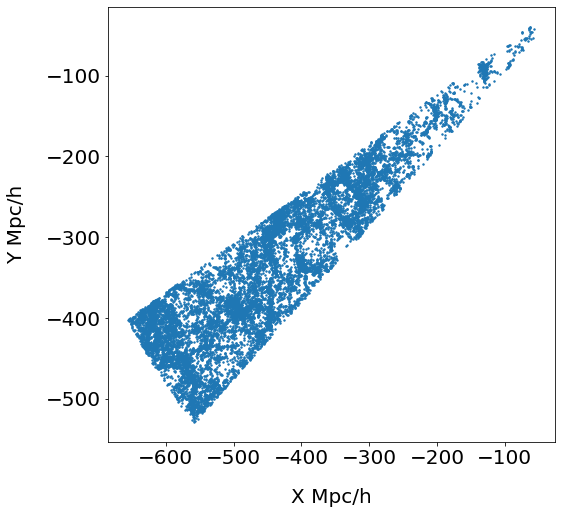

In [7]:
fig = pl.figure(figsize=(8,8))
pl.scatter( X, Y, s=2 )
pl.xlabel('X Mpc/h')
pl.ylabel('Y Mpc/h')
pl.show()

In [8]:
data = np.c_[X, Y, Z]

In [9]:
import ray
from sconce.EucSCMS_RayFunc import KDE_Ray, MS_Ray, SCMSLog_Ray
import pickle
from astropy.cosmology import WMAP9

In [ ]:
for fac in [0.4]:#, 0.8, 1.2, 1.5, 1.8, 2]:
    d = data.shape[1]
    n = data.shape[0]
    bw_Eu = fac*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))
    print("The current bandwidth for Euclidean SCMS is "+ str(bw_Eu) + ".\n")
    
    # Removing some noisy observations
    # d_Eu_dat = KDE(Eu_dat, Eu_dat, h=bw_Eu)
    ray.init()
    mesh_0 = data
    dataset = data
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(KDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu))
    d_Eu_dat = ray.get(result_ids)
    d_Eu_dat = np.concatenate(d_Eu_dat, axis=0)
    ray.shutdown()
    
    tau = np.std(d_Eu_dat)
    Eu_dat_thres = data[d_Eu_dat >= tau,:]
    if Eu_dat_thres.shape[0]/data.shape[0] < 0.8:
        Eu_dat_thres = data[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
    print("Euclidean Thresholding Ratio: "+str(Eu_dat_thres.shape[0]/data.shape[0]))
    
    nrows, ncols = (90, 90)
    lon_m, lat_m, Z_m = np.meshgrid(np.linspace(0, 90, ncols), np.linspace(0, 90, nrows), 
                                    np.linspace(min(data_gama['ZGAMA']), max(data_gama['ZGAMA']), 15))
    xg = Z_m * np.cos(lon_m/180 * np.pi) * np.cos(lat_m/180 * np.pi)
    yg = Z_m * np.sin(lon_m/180 * np.pi) * np.cos(lat_m/180 * np.pi)
    zg = Z_m * np.sin(lat_m/180 * np.pi)
    mesh_Eu = np.concatenate([xg.reshape(-1,1), yg.reshape(-1,1), zg.reshape(-1,1)], axis=1)
    
    ray.init()
    mesh_0 = mesh_Eu
    dataset = Eu_dat_thres
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(KDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu))
    d_m_Eu = ray.get(result_ids)
    d_m_Eu = np.concatenate(d_m_Eu, axis=0)
    ray.shutdown()
    
    # Thresholding
    mesh_Eu_thres = mesh_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh_Eu_thres.shape[0]/mesh_Eu.shape[0]))
    
    # MS
    ray.init()
    mesh_0 = mesh_Eu_thres
    dataset = Eu_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu, 
                                        eps=1e-7, max_iter=5000))
    EuMS_pts = ray.get(result_ids)
    EuMS_pts = np.concatenate(EuMS_pts, axis=0)
    ray.shutdown()
    
    with open(f'./data/sconce_filaments_{fac}.dat', "wb") as file:
        pickle.dump([bw_Eu, EuMS_pts], file)
        
    # SCMS
    # start = time.time()
    ray.init()
    mesh_0 = mesh_Eu_thres
    dataset = Eu_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=bw_Eu, 
                                             eps=1e-7, max_iter=5000))
    EuSCMS_pts = ray.get(result_ids)
    EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
    ray.shutdown()
    
    # print("Elasped time: "+ str(time.time()-start)+'s.\n')   
    with open(f'./data/sconce_filaments_{fac}.dat', 'wb') as file:
        pickle.dump([bw_Eu, EuSCMS_pts], file)

The current bandwidth for Euclidean SCMS is 1.1346366356586035.



2022-08-19 00:33:31,762	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


Euclidean Thresholding Ratio: 0.7999754871920578


2022-08-19 00:34:06,262	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


In [ ]:
## Loading the standard SCMS filaments in the observed redshift space
with open('./data/sconce_filaments_0.4.dat', "rb") as file:
    bw_Eu, EuFila_obs = pickle.load(file)

X_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,0]).value
Y_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,1]).value
Z_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,2]).value

EuFila_obs_comov = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T

In [ ]:
pl.rcParams.update({'font.size': 17})  # Change the font sizes of ouput figures
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(10, 40)
ax.scatter3D(X, Y, Z, color='grey', alpha=0.3, s=0.1)
ax.scatter3D(EuFila_obs_comov[:,0], EuFila_obs_comov[:,1], EuFila_obs_comov[:,2], color='blue', 
             alpha=1, s=5, label='Standard SCMS filaments in the observed redshift space')
ax.set_xlabel('Mpc/h')
ax.set_ylabel('Mpc/h')
ax.set_zlabel('Mpc/h')
pl.legend(markerscale=3)
# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False

ax.grid(False)
# ax.set_xlim(0, 75)
# ax.set_ylim(0, 75)
# ax.set_zlim(0, 75)
fig.tight_layout()
# fig.savefig('./Figures/Eu_SCMS_illustris.jpg', bbox_inches="tight", dpi=150)
pl.show()